Traditional Metrics (No Threshold Adjustment):
Accuracy: 0.8500
Precision: 0.8767
Recall: 0.8258
F1-Score: 0.8505

With the new function, we found that the best accuracy match is when Threshold is 0.4242 and here are the other eval metrics:
Final Accuracy: 0.8667
Final Precision: 0.8616
Final Recall: 0.8839
Final F1-Score: 0.8726


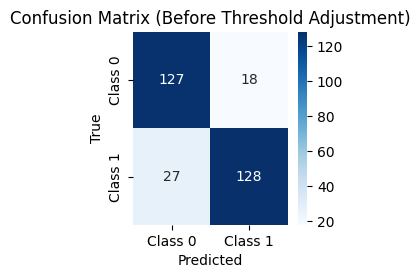

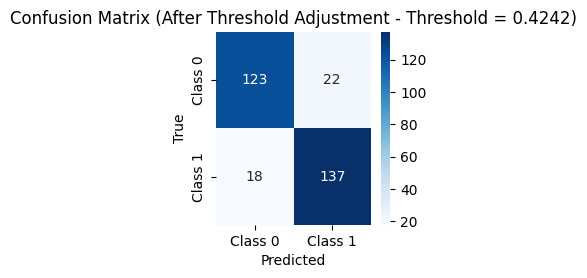

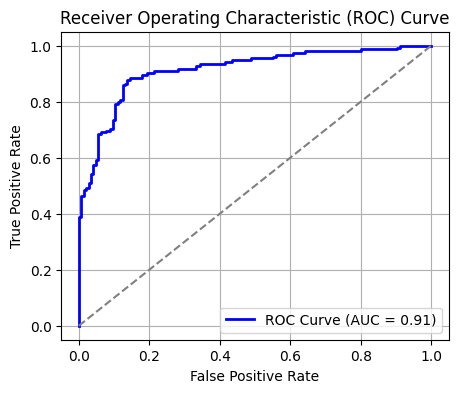

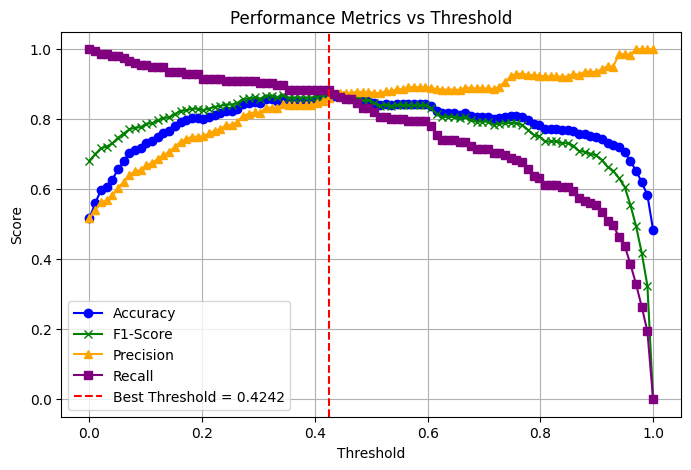

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Generate a synthetic dataset for binary classification
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Traditional evaluation using the model's default predictions (threshold = 0.5)
y_pred_default = model.predict(X_test)

# Calculate traditional metrics
accuracy_default = accuracy_score(y_test, y_pred_default)
precision_default = precision_score(y_test, y_pred_default, zero_division=1)
recall_default = recall_score(y_test, y_pred_default)
f1_default = f1_score(y_test, y_pred_default)

print("Traditional Metrics (No Threshold Adjustment):")
print(f"Accuracy: {accuracy_default:.4f}")
print(f"Precision: {precision_default:.4f}")
print(f"Recall: {recall_default:.4f}")
print(f"F1-Score: {f1_default:.4f}")

# New function for optimizing threshold based on accuracy and F1-score
from sklearn.model_selection import cross_val_score, StratifiedKFold

def find_best_threshold_with_f1_cv(model, X_train, y_train, X_test, y_test, thresholds_to_check=np.linspace(0, 1, 100)):
    # Initialize cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Placeholder to store cross-validated F1 scores for each threshold
    best_threshold = 0
    best_accuracy = 0
    best_f1 = 0
    
    for threshold in thresholds_to_check:
        accuracies = []
        f1_scores = []
        
        for train_index, val_index in cv.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            model.fit(X_train_fold, y_train_fold)
            y_probs = model.predict_proba(X_val_fold)[:, 1]
            y_pred = (y_probs >= threshold).astype(int)
            
            accuracies.append(accuracy_score(y_val_fold, y_pred))
            f1_scores.append(f1_score(y_val_fold, y_pred))
        
        avg_accuracy = np.mean(accuracies)
        avg_f1 = np.mean(f1_scores)
        
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_f1 = avg_f1
            best_threshold = threshold
        elif avg_accuracy == best_accuracy and avg_f1 > best_f1:
            best_f1 = avg_f1
            best_threshold = threshold

    return best_threshold, best_accuracy, best_f1


# Find the best threshold and corresponding metrics
best_threshold, best_accuracy, best_f1 = find_best_threshold_with_f1(model, X_test, y_test)

# Predict with the best threshold
y_probs = model.predict_proba(X_test)[:, 1]
y_pred_final = (y_probs >= best_threshold).astype(int)

# Final accuracy and F1-score
final_accuracy = accuracy_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final, zero_division=1)
final_recall = recall_score(y_test, y_pred_final)

# Print the results in the requested format
print("\nWith the new function, we found that the best accuracy match is when Threshold is {:.4f} and here are the other eval metrics:".format(best_threshold))
print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Precision: {final_precision:.4f}")
print(f"Final Recall: {final_recall:.4f}")
print(f"Final F1-Score: {final_f1:.4f}")

# Plot confusion matrix before and after threshold adjustment
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(2.5,2.5))  # Adjusted to a smaller size for Jupyter
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Confusion matrix before threshold adjustment (using default threshold of 0.5)
plot_confusion_matrix(y_test, y_pred_default, "Confusion Matrix (Before Threshold Adjustment)")

# Confusion matrix after threshold adjustment (using the best threshold)
plot_confusion_matrix(y_test, y_pred_final, f"Confusion Matrix (After Threshold Adjustment - Threshold = {best_threshold:.4f})")

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(5, 4))  # Set a smaller figure size
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confidence Metrics vs Thresholds
thresholds_to_plot = np.linspace(0, 1, 100)
accuracies = []
f1_scores = []
precisions = []
recalls = []

for threshold in thresholds_to_plot:
    y_pred = (y_probs >= threshold).astype(int)
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, zero_division=1))
    recalls.append(recall_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(thresholds_to_plot, accuracies, label='Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(thresholds_to_plot, f1_scores, label='F1-Score', color='green', linestyle='-', marker='x')
plt.plot(thresholds_to_plot, precisions, label='Precision', color='orange', linestyle='-', marker='^')
plt.plot(thresholds_to_plot, recalls, label='Recall', color='purple', linestyle='-', marker='s')

# Mark the best threshold
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.4f}')
plt.title('Performance Metrics vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


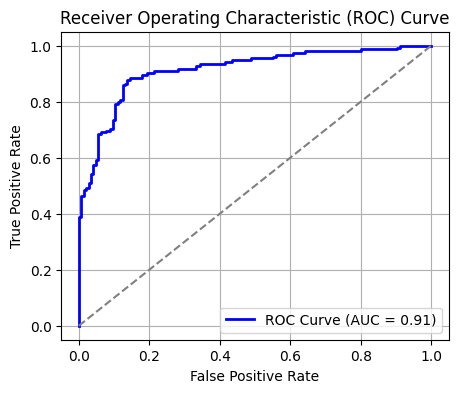

Best Threshold (based on Youden's Index) according to ROC Curve: 0.4304


In [2]:
# ROC Curve Plot
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Calculate Youden's Index (Sensitivity + Specificity - 1)
youden_index = tpr - fpr

# Find the threshold that maximizes Youden's Index
best_threshold_roc = thresholds_roc[np.argmax(youden_index)]

# Plot the ROC Curve
plt.figure(figsize=(5, 4))  # Set a smaller figure size
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the best threshold according to ROC curve
print(f"Best Threshold (based on Youden's Index) according to ROC Curve: {best_threshold_roc:.4f}")


Performance Metrics at Threshold = 0.4304:
Accuracy: 0.8667
Precision: 0.8710
Recall: 0.8710
F1-Score: 0.8710

Performance Metrics at Best Threshold from our Function (0.4242):
Accuracy: 0.8667
Precision: 0.8616
Recall: 0.8839
F1-Score: 0.8726

Confusion Matrix for Threshold = 0.4304 (ROC Curve):


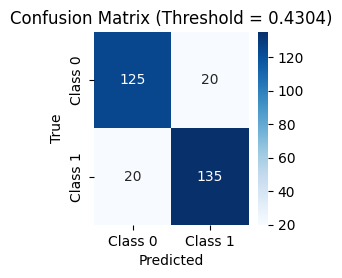


Confusion Matrix for Best Threshold from our Function (Threshold = 0.4242):


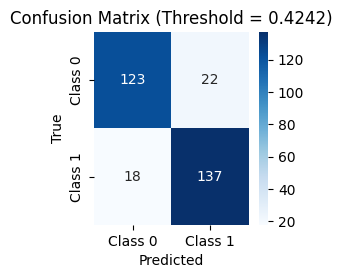

In [3]:
# Check performance at threshold = 0.4304 (from ROC curve)
threshold_roc = 0.4304

# Predict with threshold = 0.4304
y_pred_roc = (y_probs >= threshold_roc).astype(int)

# Calculate performance metrics at threshold = 0.4304
roc_accuracy = accuracy_score(y_test, y_pred_roc)
roc_precision = precision_score(y_test, y_pred_roc, zero_division=1)
roc_recall = recall_score(y_test, y_pred_roc)
roc_f1 = f1_score(y_test, y_pred_roc)

# Print the performance metrics at threshold = 0.4304
print(f"Performance Metrics at Threshold = {threshold_roc:.4f}:")
print(f"Accuracy: {roc_accuracy:.4f}")
print(f"Precision: {roc_precision:.4f}")
print(f"Recall: {roc_recall:.4f}")
print(f"F1-Score: {roc_f1:.4f}")

# Compare with performance metrics at best threshold from our function (0.4242)
best_threshold_from_function = 0.4242

# Predict with the best threshold from our function (0.4242)
y_pred_function = (y_probs >= best_threshold_from_function).astype(int)

# Calculate performance metrics at threshold = 0.4242
function_accuracy = accuracy_score(y_test, y_pred_function)
function_precision = precision_score(y_test, y_pred_function, zero_division=1)
function_recall = recall_score(y_test, y_pred_function)
function_f1 = f1_score(y_test, y_pred_function)

# Print the performance metrics at the best threshold from our function (0.4242)
print(f"\nPerformance Metrics at Best Threshold from our Function ({best_threshold_from_function:.4f}):")
print(f"Accuracy: {function_accuracy:.4f}")
print(f"Precision: {function_precision:.4f}")
print(f"Recall: {function_recall:.4f}")
print(f"F1-Score: {function_f1:.4f}")

# Compare Confusion Matrices

# Confusion matrix for threshold 0.4304 (from ROC curve)
print("\nConfusion Matrix for Threshold = 0.4304 (ROC Curve):")
plot_confusion_matrix(y_test, y_pred_roc, f"Confusion Matrix (Threshold = {threshold_roc:.4f})")

# Confusion matrix for best threshold from our function (0.4242)
print("\nConfusion Matrix for Best Threshold from our Function (Threshold = 0.4242):")
plot_confusion_matrix(y_test, y_pred_function, f"Confusion Matrix (Threshold = {best_threshold_from_function:.4f})")


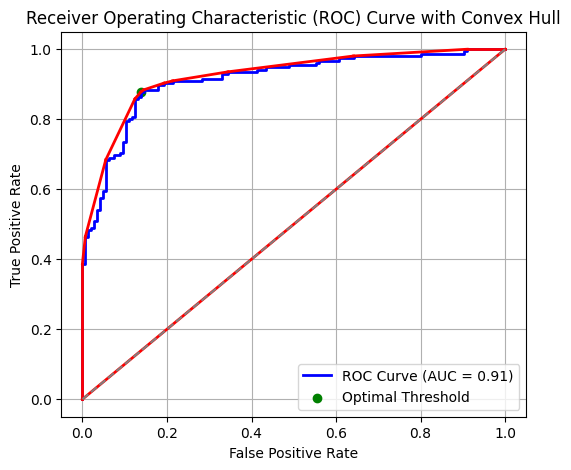

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from scipy.spatial import ConvexHull

# Generate a synthetic dataset for binary classification
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# ROC Curve: Get the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Compute the Convex Hull for the ROC points
points = np.column_stack((fpr, tpr))
hull = ConvexHull(points)

# Plot the ROC curve and the Convex Hull
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')

# Plot the Convex Hull
for simplex in hull.simplices:
    plt.plot(fpr[simplex], tpr[simplex], color='red', lw=2)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (Random classifier)

# Mark the optimal point (usually the top-left point of the ROC curve)
optimal_idx = np.argmax(tpr - fpr)
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='green', marker='o', label='Optimal Threshold')

# Add labels and title
plt.title('Receiver Operating Characteristic (ROC) Curve with Convex Hull')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Optimal Threshold: 0.4304
Accuracy: 0.8700
Precision: 0.8718
Recall: 0.8774
F1-Score: 0.8746


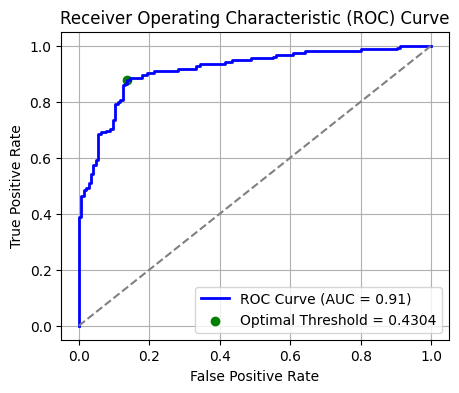

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Generate a synthetic dataset for binary classification
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Get predicted probabilities for the positive class (class 1)
y_probs = model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold by maximizing (TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]  # This is the threshold that maximizes (TPR - FPR)

print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Use the optimal threshold to make predictions
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

# Evaluate the model with the optimal threshold
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='green', marker='o', label=f'Optimal Threshold = {optimal_threshold:.4f}')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


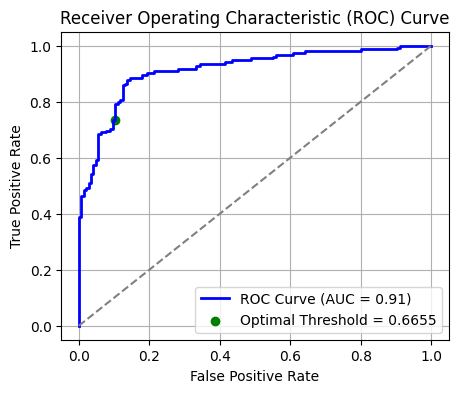

AUC: 0.9142
Accuracy: 0.8167
Precision: 0.8906
Recall: 0.7355
F1-Score: 0.8057


In [18]:
from sklearn.metrics import roc_curve, auc

# Define optimal threshold
optimal_threshold = 0.6655

# Use the model's predicted probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve with AUC
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.scatter(fpr[np.argmin(np.abs(thresholds - optimal_threshold))], 
            tpr[np.argmin(np.abs(thresholds - optimal_threshold))], 
            color='green', marker='o', label=f'Optimal Threshold = {optimal_threshold:.4f}')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Get the predicted classes based on the optimal threshold
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

# Calculate accuracy, precision, recall, and F1-score at the optimal threshold
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)

# Print the results
print(f"AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


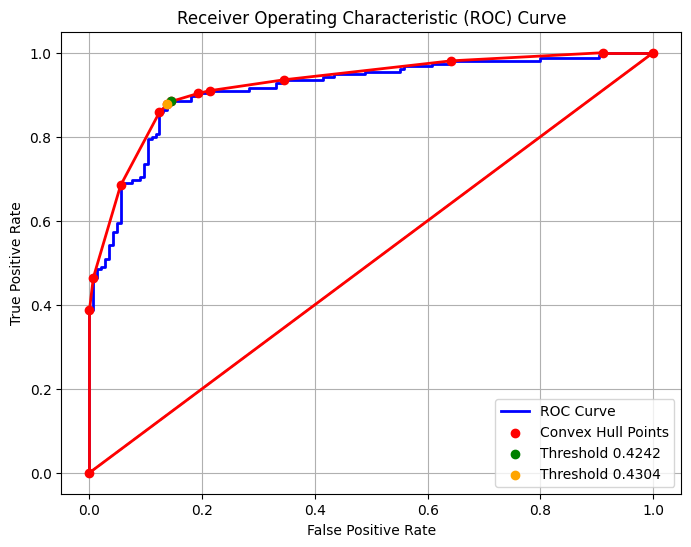

Threshold 0.4242 is on the convex hull.
Threshold 0.4304 is on the convex hull.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from scipy.spatial import ConvexHull

# Assuming y_test and y_probs are available from your model's output
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Now, calculate the convex hull
points = np.column_stack((fpr, tpr))  # Combine fpr and tpr
hull = ConvexHull(points)

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-', lw=2)

# Mark the convex hull points
plt.scatter(fpr[hull.vertices], tpr[hull.vertices], color='red', zorder=10, label='Convex Hull Points')

# Highlight the thresholds 0.4242 and 0.4304 on the ROC curve
# Find the corresponding indices for these thresholds
threshold_0_4242_idx = np.argmin(np.abs(thresholds - 0.4242))
threshold_0_4304_idx = np.argmin(np.abs(thresholds - 0.4304))

# Plot the points for these thresholds
plt.scatter(fpr[threshold_0_4242_idx], tpr[threshold_0_4242_idx], color='green', zorder=10, label='Threshold 0.4242')
plt.scatter(fpr[threshold_0_4304_idx], tpr[threshold_0_4304_idx], color='orange', zorder=10, label='Threshold 0.4304')

# Show legend and plot
plt.legend()
plt.grid(True)
plt.show()

# Check if these thresholds are part of the convex hull
if threshold_0_4242_idx in hull.vertices:
    print("Threshold 0.4242 is on the convex hull.")
else:
    print("Threshold 0.4242 is not on the convex hull.")

if threshold_0_4304_idx in hull.vertices:
    print("Threshold 0.4304 is on the convex hull.")
else:
    print("Threshold 0.4304 is not on the convex hull.")


   Threshold  Accuracy  Precision    Recall  F1-Score
0     0.4242  0.866667   0.861635  0.883871  0.872611
1     0.4304  0.866667   0.870968  0.870968  0.870968


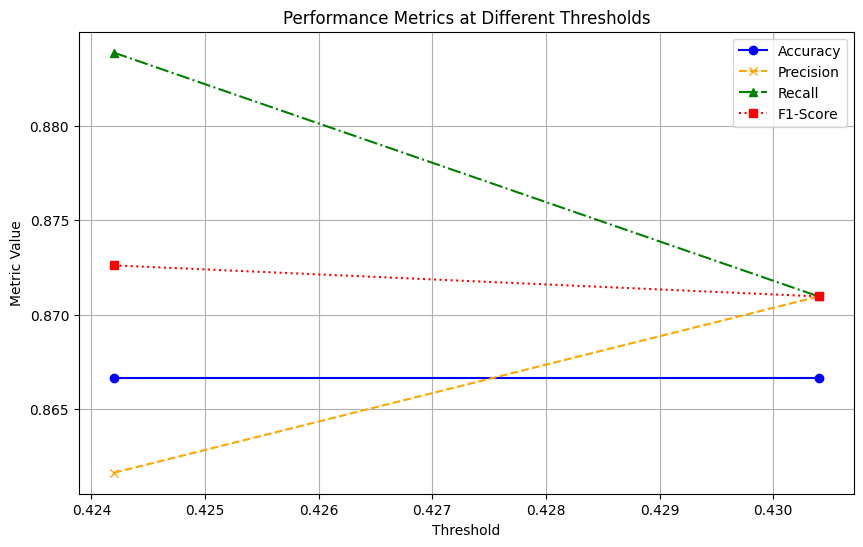

In [20]:
# Evaluate the model at thresholds 0.4242 and 0.4304
thresholds_to_check = [0.4242, 0.4304]

# Placeholder for storing metrics
metrics = {'Threshold': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

# Calculate metrics for each threshold
for threshold in thresholds_to_check:
    y_pred = (y_probs >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics['Threshold'].append(threshold)
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-Score'].append(f1)

# Convert the metrics to a DataFrame for easy comparison
metrics_df = pd.DataFrame(metrics)

# Display the metrics
print(metrics_df)

# Plot the metrics for better visualization
plt.figure(figsize=(10, 6))

# Plot each metric against the thresholds
plt.plot(metrics_df['Threshold'], metrics_df['Accuracy'], label='Accuracy', marker='o', color='blue', linestyle='-')
plt.plot(metrics_df['Threshold'], metrics_df['Precision'], label='Precision', marker='x', color='orange', linestyle='--')
plt.plot(metrics_df['Threshold'], metrics_df['Recall'], label='Recall', marker='^', color='green', linestyle='-.')
plt.plot(metrics_df['Threshold'], metrics_df['F1-Score'], label='F1-Score', marker='s', color='red', linestyle=':')

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Performance Metrics at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Import Cohen's Kappa
from sklearn.metrics import cohen_kappa_score

# Calculate Kappa for the default threshold (0.5)
kappa_default = cohen_kappa_score(y_test, y_pred_default)
print(f"Cohen's Kappa (No Threshold Adjustment): {kappa_default:.4f}")

# Calculate Kappa for threshold 0.4242
y_pred_4242 = (y_probs >= 0.4242).astype(int)
kappa_4242 = cohen_kappa_score(y_test, y_pred_4242)
print(f"Cohen's Kappa (Threshold = 0.4242): {kappa_4242:.4f}")

# Calculate Kappa for threshold 0.4304
y_pred_4304 = (y_probs >= 0.4304).astype(int)
kappa_4304 = cohen_kappa_score(y_test, y_pred_4304)
print(f"Cohen's Kappa (Threshold = 0.4304): {kappa_4304:.4f}")

# Calculate Kappa for threshold 0.5005
y_pred_5005 = (y_probs >= 0.5005).astype(int)
kappa_5005 = cohen_kappa_score(y_test, y_pred_5005)
print(f"Cohen's Kappa (Threshold = 0.5005): {kappa_5005:.4f}")


Cohen's Kappa (No Threshold Adjustment): 0.7003
Cohen's Kappa (Threshold = 0.4242): 0.7328
Cohen's Kappa (Threshold = 0.4304): 0.7330
Cohen's Kappa (Threshold = 0.5005): 0.7003
